In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def add_summary_rows_for_plot(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    summary_rows = []

    for model in df['model'].unique():
        model_df = df[df['model'] == model]

        # 1. comedi-avg
        comedi = model_df[model_df['dataset'] == 'CoMeDi']
        if not comedi.empty:
            val = comedi[metric].mean()
            summary_rows.append({'dataset_language': 'CoMeDi-Avg', 'model': model, metric: val})

        # 2. comedi-avg-without-spanish
        comedi_no_spanish = comedi[comedi['language'] != 'ES']
        if not comedi_no_spanish.empty:
            val = comedi_no_spanish[metric].mean()
            summary_rows.append({'dataset_language': 'CoMeDi-Avg-W/O-ES', 'model': model, metric: val})

        # 3. wic-avg
        wic_like = model_df[model_df['dataset'].isin(['WiC', 'MCL-WiC'])]
        if not wic_like.empty:
            val = wic_like[metric].mean()
            summary_rows.append({'dataset_language': 'WiC-Avg', 'model': model, metric: val})

    return pd.DataFrame(summary_rows)

def format_value(x):
    if pd.isnull(x):
        return ""
    s = f"{x:.2f}"
    if s.startswith("-0"):
        return "-" + s[2:]
    return s.lstrip("0")


def plot(
    combined_df: pd.DataFrame,
    metrics_to_plot: list,
    split: str = 'dev',
    x: int = 8,
    y: int = 8,
):
    df = combined_df.copy()
    df['dataset_language'] = df['dataset'] + ' / ' + df['language']

    if split in ['dev', 'test']:
        df = df[df['split'] == split]

    melted_frames = []
    summary_rows = []

    for metric in metrics_to_plot:
        if split == 'both':
            tmp = df[['dataset_language', 'model', 'split', metric]].copy()
            tmp['metric_model_split'] = metric + '_' + tmp['model'] + '_' + tmp['split']
        else:
            tmp = df[['dataset_language', 'model', metric]].copy()
            tmp['metric_model_split'] = tmp['model']

        tmp = tmp[['dataset_language', 'metric_model_split', metric]]
        tmp = tmp.rename(columns={metric: 'value'})
        melted_frames.append(tmp)

        summaries = add_summary_rows_for_plot(df, metric)
        if not summaries.empty:
            summaries['metric_model_split'] = summaries['model']
            summaries = summaries[['dataset_language', 'metric_model_split', metric]]
            summaries = summaries.rename(columns={metric: 'value'})
            summary_rows.append(summaries)

    merged = pd.concat(melted_frames + summary_rows, ignore_index=True)

    # Pivot for heatmap
    pivot_df = merged.pivot_table(
        index='dataset_language',
        columns='metric_model_split',
        values='value',
        aggfunc='mean'
    )
    model_order = [
            "CL-WiC+CoMeDi",
            "COS-WiC+CoMeDi",
            "CSENT-WiC+CoMeDi",
            "AnglE-WiC+CoMeDi",
            "CL-WiC",
            "COS-WiC",
            "CSENT-WiC",
            "AnglE-WiC",
            "CL-CoMeDi",
            "COS-CoMeDi",
            "CSENT-CoMeDi",
            "AnglE-CoMeDi",
            "SBERT",
            "XL-LXM",
            "XL-LXM-CoMeDi",
            "DMistake-CoMeDi"
        ]
    model_order = [m for m in model_order if m in pivot_df.columns]
    pivot_df = pivot_df[model_order]


    # Move summary rows to the bottom
    summary_order = ['CoMeDi-Avg', 'CoMeDi-Avg-W/O-ES', 'WiC-Avg']
    normal_rows = [idx for idx in pivot_df.index if idx not in summary_order]
    final_index_order = normal_rows + [idx for idx in summary_order if idx in pivot_df.index]
    pivot_df = pivot_df.loc[final_index_order]
    # Plot
    plt.figure(figsize=(x, y))
    annot = pivot_df.applymap(lambda x: f"{x:.2f}".lstrip('0') if pd.notnull(x) else "")
    annot_new = pivot_df.applymap(format_value)

    sns.heatmap(pivot_df,
                vmin=0.0,
                vmax=1.0,
                annot=annot_new,
                cmap='YlGnBu',
                fmt="",
                linewidths=0.5,
                cbar=True)
    if metrics_to_plot == ["krippendorff_alpha"]:
        plt.title(f"Model Comparison on Krippendorff ($\\alpha$) — {split.upper()}")
    elif metrics_to_plot == ["spearman"]:
        plt.title(f"Model Comparison on Spearman rank correlation — {split.upper()}")

    plt.xlabel("Model")
    plt.ylabel("Dataset / Language")
    plt.show()

 


In [2]:
lang_map = {
    "english": "EN",
    "chinese": "ZH",
    "russian": "RU",
    "french": "FR",
    "norwegian": "NO",
    "swedish": "SV",
    "german": "DE",
    "arabic": "AR",
    "spanish": "ES"
}

/tmp/ipykernel_2946870/3847160957.py:113: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = pivot_df.applymap(lambda x: f"{x:.2f}".lstrip('0') if pd.notnull(x) else "")
/tmp/ipykernel_2946870/3847160957.py:114: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_new = pivot_df.applymap(format_value)


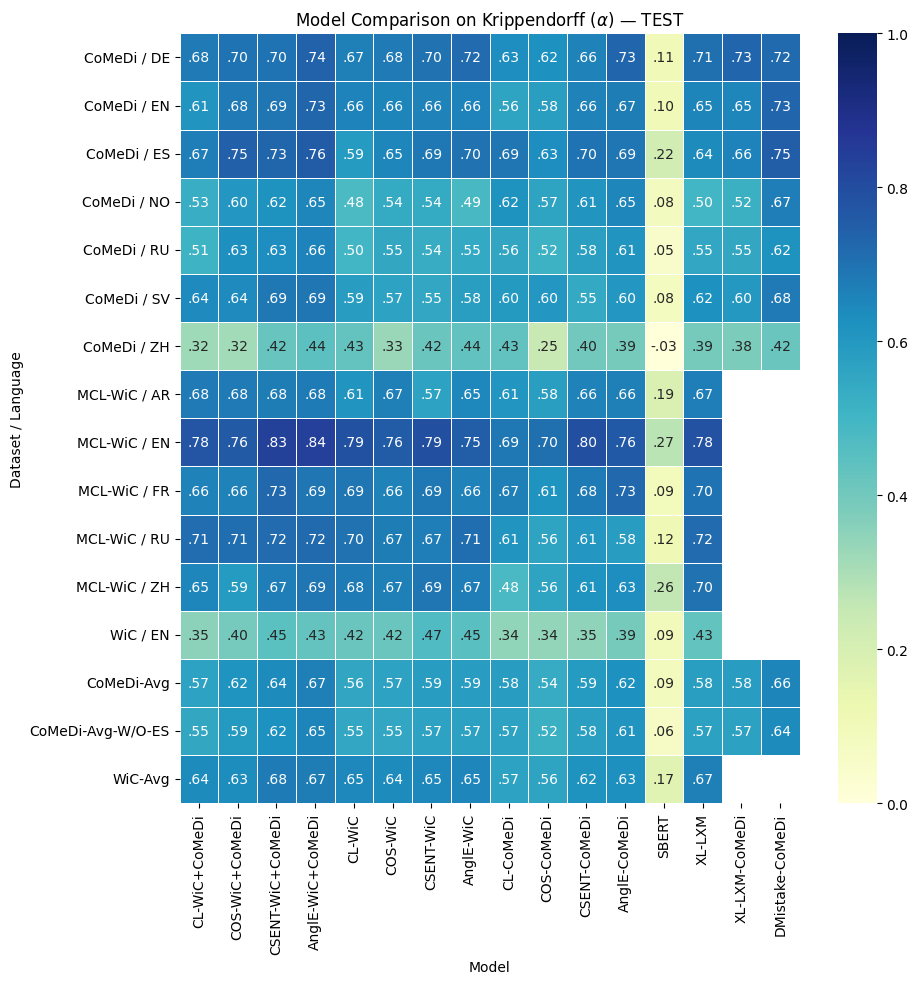

In [3]:
path = "krippendorff"

# ================= WiC + CoMeDi =================
AnglE_WiC_CoMeDi = pd.read_csv(f"{path}/AnglE-WiC+CoMeDi.csv")
AnglE_WiC_CoMeDi["model"] = "AnglE-WiC+CoMeDi"
AnglE_WiC_CoMeDi["split"] = "test"

CSENT_WiC_CoMeDi = pd.read_csv(f"{path}/CSENT-WiC+CoMeDi.csv")
CSENT_WiC_CoMeDi["model"] = "CSENT-WiC+CoMeDi"
CSENT_WiC_CoMeDi["split"] = "test"

COS_WiC_CoMeDi = pd.read_csv(f"{path}/COS-WiC+CoMeDi.csv")
COS_WiC_CoMeDi["model"] = "COS-WiC+CoMeDi"
COS_WiC_CoMeDi["split"] = "test"

CL_WiC_CoMeDi = pd.read_csv(f"{path}/CL-WiC+CoMeDi.csv")
CL_WiC_CoMeDi["model"] = "CL-WiC+CoMeDi"
CL_WiC_CoMeDi["split"] = "test"

# ================= WiC =================
AnglE_WiC = pd.read_csv(f"{path}/AnglE-WiC.csv")
AnglE_WiC["model"] = "AnglE-WiC"
AnglE_WiC["split"] = "test"

CSENT_WiC = pd.read_csv(f"{path}/CSENT-WiC.csv")
CSENT_WiC["model"] = "CSENT-WiC"
CSENT_WiC["split"] = "test"

COS_WiC = pd.read_csv(f"{path}/COS-WiC.csv")
COS_WiC["model"] = "COS-WiC"
COS_WiC["split"] = "test"

CL_WiC = pd.read_csv(f"{path}/CL-WiC.csv")
CL_WiC["model"] = "CL-WiC"
CL_WiC["split"] = "test"

# ================= CoMeDi =================
CL_CoMeDi = pd.read_csv(f"{path}/CL-CoMeDi.csv")
CL_CoMeDi["model"] = "CL-CoMeDi"
CL_CoMeDi["split"] = "test"

AnglE_CoMeDi = pd.read_csv(f"{path}/AnglE-CoMeDi.csv")
AnglE_CoMeDi["model"] = "AnglE-CoMeDi"
AnglE_CoMeDi["split"] = "test"

COS_CoMeDi = pd.read_csv(f"{path}/COS-CoMeDi.csv")
COS_CoMeDi["model"] = "COS-CoMeDi"
COS_CoMeDi["split"] = "test"

CSENT_CoMeDi = pd.read_csv(f"{path}/CSENT-CoMeDi.csv")
CSENT_CoMeDi["model"] = "CSENT-CoMeDi"
CSENT_CoMeDi["split"] = "test"

# ================= Other models =================
XL_LXM = pd.read_csv(f"{path}/XL-LXM.csv")
XL_LXM["model"] = "XL-LXM"
XL_LXM["split"] = "test"

XL_LXM_CoMeDi = pd.read_csv(f"{path}/XL-LXM-CoMeDi.csv")
XL_LXM_CoMeDi["model"] = "XL-LXM-CoMeDi"
XL_LXM_CoMeDi["split"] = "test"

DMistake_CoMeDi = pd.read_csv(f"{path}/DMistake-CoMeDi.csv")
DMistake_CoMeDi["model"] = "DMistake-CoMeDi"
DMistake_CoMeDi["split"] = "test"

SBERT = pd.read_csv(f"{path}/SBERT.csv")
SBERT["model"] = "SBERT"
SBERT["split"] = "test"



combined_df = pd.concat([
    XL_LXM, AnglE_WiC, CSENT_WiC, CL_WiC, COS_WiC,
    AnglE_WiC_CoMeDi, CSENT_WiC_CoMeDi, COS_WiC_CoMeDi, CL_WiC_CoMeDi,
    CL_CoMeDi, AnglE_CoMeDi, COS_CoMeDi, CSENT_CoMeDi,
    XL_LXM_CoMeDi, DMistake_CoMeDi, SBERT
], ignore_index=True)

combined_df["language"] = combined_df["language"].map(lang_map)

combined_df["dataset"] = combined_df["dataset"].replace({
    "comedi": "CoMeDi",
    "wic": "WiC",
    "mcl-wic": "MCL-WiC"
})

# ================= Plot =================
plot(combined_df, ["krippendorff_alpha"], split="test", x=10, y=10)


/tmp/ipykernel_2946870/3847160957.py:113: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = pivot_df.applymap(lambda x: f"{x:.2f}".lstrip('0') if pd.notnull(x) else "")
/tmp/ipykernel_2946870/3847160957.py:114: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_new = pivot_df.applymap(format_value)


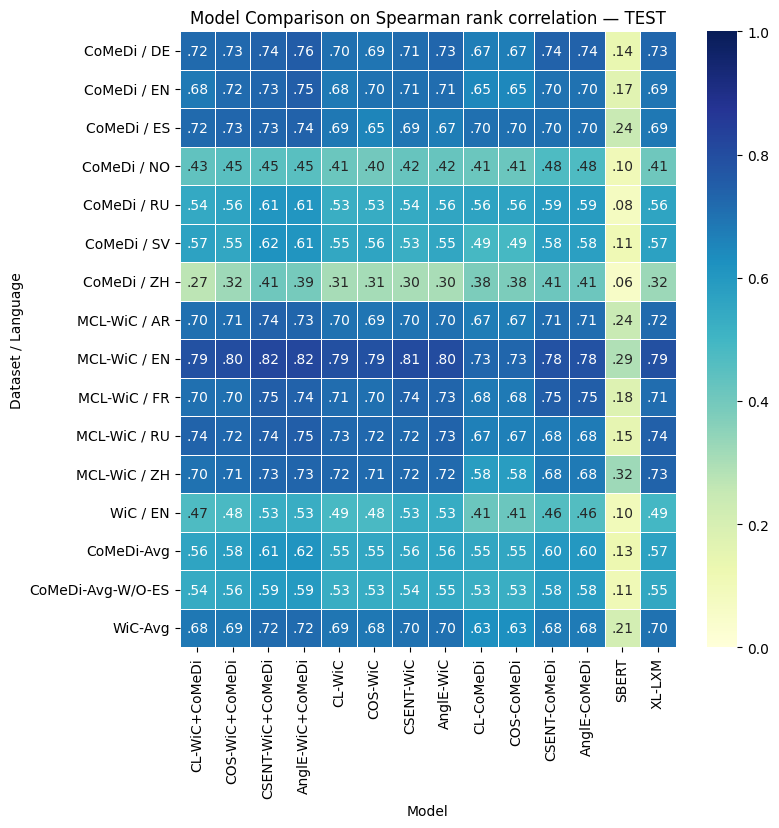

In [4]:
import pandas as pd

base_path = 'spearman'

# ================= WiC + CoMeDi =================
AnglE_WiC_CoMeDi = pd.read_csv(f'{base_path}/AnglE-WiC+CoMeDi.csv')
AnglE_WiC_CoMeDi['model'] = 'AnglE-WiC+CoMeDi'
AnglE_WiC_CoMeDi['split'] = 'test'

CSENT_WiC_CoMeDi = pd.read_csv(f'{base_path}/CSENT-WiC+CoMeDi.csv')
CSENT_WiC_CoMeDi['model'] = 'CSENT-WiC+CoMeDi'
CSENT_WiC_CoMeDi['split'] = 'test'

COS_WiC_CoMeDi = pd.read_csv(f'{base_path}/COS-WiC+CoMeDi.csv')
COS_WiC_CoMeDi['model'] = 'COS-WiC+CoMeDi'
COS_WiC_CoMeDi['split'] = 'test'

CL_WiC_CoMeDi = pd.read_csv(f'{base_path}/CL-WiC+CoMeDi.csv')
CL_WiC_CoMeDi['model'] = 'CL-WiC+CoMeDi'
CL_WiC_CoMeDi['split'] = 'test'

# ================= WiC =================
CL_WiC = pd.read_csv(f'{base_path}/CL-WiC.csv')
CL_WiC['model'] = 'CL-WiC'
CL_WiC['split'] = 'test'

AnglE_WiC = pd.read_csv(f'{base_path}/AnglE-WiC.csv')
AnglE_WiC['model'] = 'AnglE-WiC'
AnglE_WiC['split'] = 'test'

COS_WiC = pd.read_csv(f'{base_path}/COS-WiC.csv')
COS_WiC['model'] = 'COS-WiC'
COS_WiC['split'] = 'test'

CSENT_WiC = pd.read_csv(f'{base_path}/CSENT-WiC.csv')
CSENT_WiC['model'] = 'CSENT-WiC'
CSENT_WiC['split'] = 'test'

# ================= CoMeDi =================
CL_CoMeDi = pd.read_csv(f'{base_path}/CL-CoMeDi.csv')
CL_CoMeDi['model'] = 'CL-CoMeDi'
CL_CoMeDi['split'] = 'test'

AnglE_CoMeDi = pd.read_csv(f'{base_path}/AnglE-CoMeDi.csv')
AnglE_CoMeDi['model'] = 'AnglE-CoMeDi'
AnglE_CoMeDi['split'] = 'test'

COS_CoMeDi = pd.read_csv(f'{base_path}/COS-CoMeDi.csv')
COS_CoMeDi['model'] = 'COS-CoMeDi'
COS_CoMeDi['split'] = 'test'

CSENT_CoMeDi = pd.read_csv(f'{base_path}/CSENT-CoMeDi.csv')
CSENT_CoMeDi['model'] = 'CSENT-CoMeDi'
CSENT_CoMeDi['split'] = 'test'

# ================= Other models =================
XL_LXM = pd.read_csv(f'{base_path}/XL-LXM.csv')
XL_LXM['model'] = 'XL-LXM'
XL_LXM['split'] = 'test'

SBERT = pd.read_csv(f'{base_path}/SBERT.csv')
SBERT['model'] = 'SBERT'
SBERT['split'] = 'test'


combined_df = pd.concat([
    XL_LXM, SBERT, CL_WiC, AnglE_WiC, COS_WiC, CSENT_WiC,
    CL_CoMeDi, AnglE_CoMeDi, COS_CoMeDi, CSENT_CoMeDi,
    AnglE_WiC_CoMeDi, CSENT_WiC_CoMeDi, COS_WiC_CoMeDi, CL_WiC_CoMeDi
], ignore_index=True)

combined_df['language'] = combined_df['language'].map(lang_map)

combined_df['dataset'] = combined_df['dataset'].replace({
    'comedi': 'CoMeDi',
    'wic': 'WiC',
    'mcl-wic': 'MCL-WiC'
})

# ================= Plot =================
plot(combined_df, ['spearman'], split='test', x=8, y=8)
